# 3D single case.

In this example all patterns will be sampled from one 3D image.
Once the patterns are sampled we'll set a selection threshold to extract the pattern bank.
From the pattern bank we'll recreate the image using only meningful patterns.

### WORK IN PROGRESS!!!
### Pattern samplig.

Each image is a set of points in N<sup>3</sup>, therefore we can sample this space using a finite set of [0,patch_size]<sup>3</sup> subspaces. Each sample can be univocally encoded with a natural number as 
$$pattern=\sum_{i=0,j=0,k=0}^p x^{i+j+k}$$

### Maximizing entropy.

### Recreate image.


## Import

In [1]:
import nii_io as nio
import nii_utils as utils
import nii_settings as nst
import nii_MDV as mdv
import numpy as np
from sklearn.mixture import GMM
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, axes, sci
from IPython.display import display, Image #Config the matlotlib backend as plotting inline in IPython
import pylab

import pprint
pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Settings

In [2]:
proj_dir = "."
nii_dir = "./brainNii"
nii_segm_dir = "./brainNii/segmentation"
nii_settings_name = "settings.json"
nii_data_name = "patterns.json"
nii_histogram_name = "histogram.json"
nii_output_dir = "./brainNii/output"
nii_compressd_dir = "./brainNii/compressd"

extensions = ['.nii']

settings = utils.loadDict(proj_dir,nii_settings_name)
if settings == None:
    settings = nst.createSettings(nii_dir,extensions)
utils.saveDict(proj_dir,nii_settings_name,settings)
    
data = utils.loadDict(proj_dir,nii_data_name) # load data 
data = {} if data == None else data

print 'sampled data size'
print '3x3x3 patterns 2 bits per pixel = 54 bits per pattern'
print 'numeber of patter sampled: ' + `len(data.keys())`
print 'total size of pattern sampled: ' + `((len(data.keys())* 54) / 8) /1024` + ' Kbytes' + '\n'

pp.pprint(settings)

sampled data size
3x3x3 patterns 2 bits per pixel = 54 bits per pattern
numeber of patter sampled: 0
total size of pattern sampled: 0 Kbytes

{   'done_dirlist': [   'AD-1.nii',
                        'CTRL-10.nii',
                        'CONV-30.nii',
                        'NOCONV-50.nii',
                        'NOCONV-10.nii',
                        'CTRL-5.nii'],
    'thress': {   'AD-7.nii': [   0.1253376906090581,
                                  0.32831875008302286,
                                  0.5264969822905372,
                                  1.0485159228165726]},
    'todo_dirlist': ['AD-7.nii']}


## Algorythm parameters

In [3]:
patch_side = 3  # considering cubic pathces
W = 0.5 # frequency
N = 64 # #(pattern_bank)
precision_=0.001 # bins precision

# Starting sampling

First we'll sample every image on its own.

In [ ]:
images_samples = {}
images_samplers = {}
images_data_and_metadata = {}

for img_name in settings['todo_dirlist']:
    # by default thresholds are loaded, than a sampler is instanciated,
    # secondly image data is loaded in memory.
    images_samples[img_name] = utils.loadDict(proj_dir,img_name  + '_' + nii_data_name)
    images_samplers[img_name] = mdv.Sampler(patch_side,settings['thress'][img_name])
    images_data_and_metadata[img_name] = nio.basicLoadNii(utils.joinpath(nii_dir,img_name))
    if images_samples[img_name] == None:
        print "sample not on disk for case " + img_name + ", will be created."
        image = images_data_and_metadata[img_name][2] # (header,affine,data(mmap))
        %time images_samples[img_name] = images_samplers[img_name].sample3D(image,encode_extremes=True,verbose=True)
        utils.saveDict(proj_dir,img_name  + '_' + nii_data_name, images_samples[img_name])
        print "sample for case "+ img_name + " saved to disk."
    else:
        print "sample for case "+ img_name + " loaded in memory."

sample not on disk for case AD-7.nii, will be created.
start
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


# Now create the histogram 

Use the binnedHistogram class create the density mapping.
Binning is very simple right now but might be usefull to use more redifined bins.

CPU times: user 3.16 s, sys: 68 ms, total: 3.22 s
Wall time: 3.16 s
AD-7.nii pattern distribution.


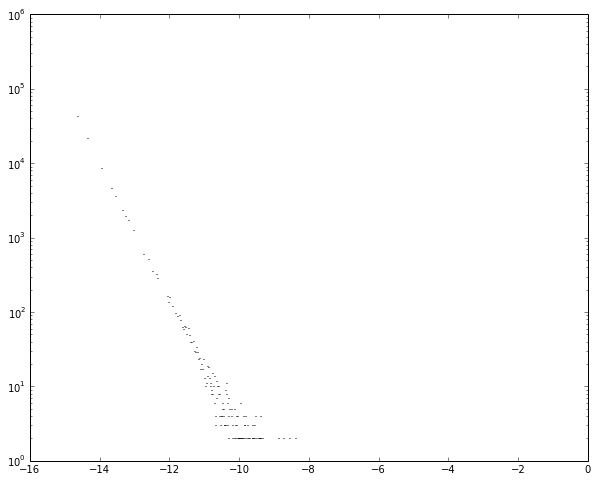

In [6]:
images_binned_hist = {}
for img_name in settings['todo_dirlist']:
    %time images_binned_hist[img_name] = mdv.binnedHistogram(precision=precision_, fun=np.log,mapkv=images_samples[img_name])
    print img_name + " pattern distribution."
    plt.bar(images_binned_hist[img_name].X, images_binned_hist[img_name].Y, width=precision_*10)
    plt.yscale('log')
    plt.show()

# Recreate the image
### Create the patterbank

Set paramenters for selection an print the resulting density

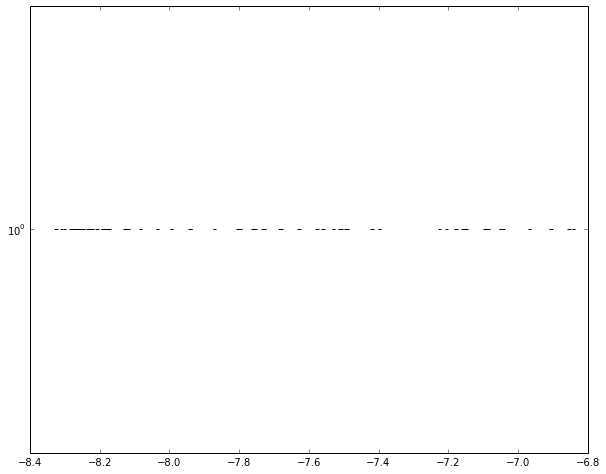

In [8]:
images_maxim = {}
images_pattern_bank = {}
for img_name in settings['todo_dirlist']:
    maxim = mdv.Maximizator(W,N)
    images_pattern_bank[img_name] = maxim.maxim(images_binned_hist[img_name])
    patternbank_bins = mdv.binnedHistogram(precision=precision_, fun=np.log, mapkv=images_pattern_bank[img_name],isMap=True)
    plt.bar(patternbank_bins.X, patternbank_bins.Y,width=precision_*10)
    plt.yscale('log')
    plt.show()
    images_pattern_bank[img_name] = []
    for v in patternbank_bins.MAP.values():
        images_pattern_bank[img_name] += map(lambda x : long(x), v)


### filter the image
Now that the pattern bank has been calculated and stored, images can be filtered.

start
progress:  100 %
ended
CPU times: user 1min 38s, sys: 432 ms, total: 1min 39s
Wall time: 1min 37s
axial


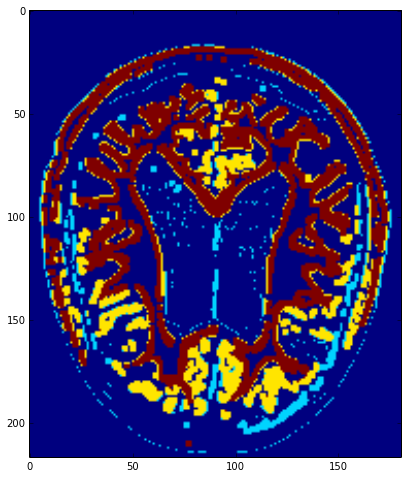

coronal


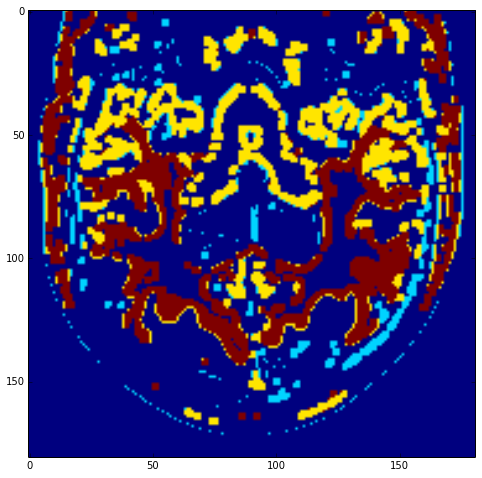

saggittal


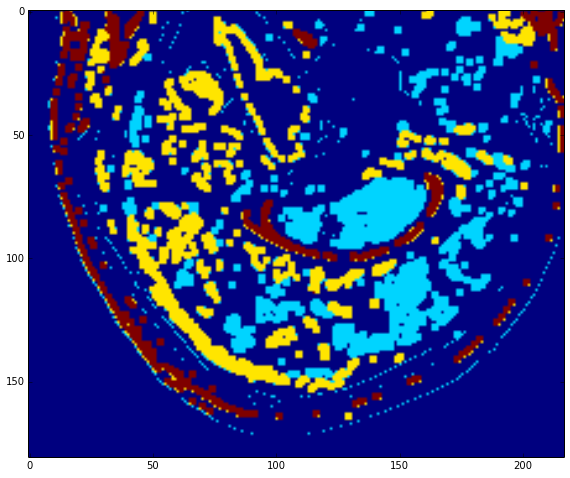

In [9]:
images_compressed = {}
for img_name in settings['todo_dirlist']:
    image_comp = mdv.Compressor(images_samplers[img_name],images_pattern_bank[img_name])
    %time image = image_comp.compress3D(images_data_and_metadata[img_name][2],encode_extremes=True, verbose=True)
    axial = image[int(image.shape[0]/2),:,:] # RL
    coronal = image[:,int(image.shape[1]/2),:] # AP
    saggittal = image[:,:,int(image.shape[2]/2)] # SI
    plt.imshow(axial)
    print 'axial'
    plt.show()
    plt.imshow(coronal)
    print 'coronal'
    plt.show()
    plt.imshow(saggittal)
    print 'saggittal'
    plt.show()
    images_compressed[img_name] = image


## Saving back to nifti

In [8]:
for img_name in settings['todo_dirlist']:
    nio.saveNii(utils.joinpath(nii_compressd_dir,img_name), images_compressed[img_name])


In [ ]:
import nii_io as nio
import nii_utils as utils
i = 0
for c_N in c_N_data:
    j = 0
    for c_j in c_N:
        nio.saveNii(utils.joinpath(nii_output_dir,'case_')+`i`+'_'+`j`+'.nii', 
                    images_meta_data[i][0], images_meta_data[i][1], c_j/float(1))
        j+=1
    
    nio.saveNii(utils.joinpath(nii_output_dir,'merged_')+`i`+'.nii',
                images_meta_data[i][0], images_meta_data[i][1],encoded_images[i]/float(1))
    i+=1